# Transform
Transform prealigned images and send it Dodam for quality check of CNN

### Reading and Writing Data

In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import h5py
import numpy as np
import src.visual as vis
from scipy.misc import imresize
path = '/FilterFinder/data/Dodam/'
path_s = '/FilterFinder/data/prealigned/'
from PIL import Image

In [2]:
def read(name, (x,y), size):
    with h5py.File(path_s+name+'.h5', 'r') as hf:
        data = hf.get('img')
        sample = np.array(data[x:x+size, y:y+size])
    return imresize(sample, (512, 512))/255.0

def get_shape(name):
    hf = h5py.File(path_s+name+'.h5', 'r')
    return hf.get('img').shape

def create_dataset(name, shape=(30159, 40229)):
    hf = h5py.File(path+name+'.h5')
    dset = hf.create_dataset("img", shape, dtype='uint8')
    return dset

def write(array, (x, y), dset):
    dset[x:x+array.shape[0], y:y+array.shape[1]] += array

def normalize(image):
    image += abs(image.min())
    image /= abs(image.max())
    image *= 255.0
    return image
    
def save(image, name='out'):
    im = image+np.abs(image.min())
    im = 255*(im/im.max())
    im = np.squeeze(im)
    #print(im.shape)
    result = Image.fromarray(im.astype(np.uint8))
    result.save(name+'.jpg')

0.25
[[ 0.00097656  0.00195312  0.00292969 ...,  0.00292969  0.00195312
   0.00097656]
 [ 0.00195312  0.00292969  0.00390625 ...,  0.00390625  0.00292969
   0.00195312]
 [ 0.00292969  0.00390625  0.00488281 ...,  0.00488281  0.00390625
   0.00292969]
 ..., 
 [ 0.00292969  0.00390625  0.00488281 ...,  0.00488281  0.00390625
   0.00292969]
 [ 0.00195312  0.00292969  0.00390625 ...,  0.00390625  0.00292969
   0.00195312]
 [ 0.00097656  0.00195312  0.00292969 ...,  0.00292969  0.00195312
   0.00097656]]


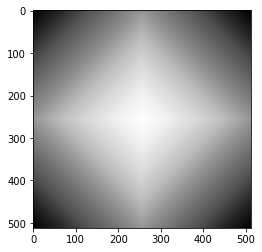

In [3]:
def f(x, y, pad, length):
    if (x>=pad and y>=pad) and (x<length-pad and y<length-pad):
        return 1

    #corners
    scale_down = 4*float(pad)
    if (x<pad and y<pad):
        return (x+y+1)/(scale_down)
    
    if (x>length-pad-1 and y>length-pad-1):
        return (2*length-x-y-1)/(scale_down)  #(length-x-1)/(2*float(pad)**2)
    
    if (x<pad and y>length-pad-1):
        return (length+x-y)/(scale_down) #y/(2*float(pad)**2)
    
    if (x>length-pad-1 and y<pad):
        return (length-x+y)/(scale_down)
    
        
    #edges
    if (x<pad) and (y>=pad and y<=length-pad-1):
        return (x+0.5)/float(pad)
    
    if (y<pad) and (x>=pad and x<=length-pad-1):
        return (y+0.5)/float(pad)
    
    if (x>pad) and (y>=pad and y<=length-pad-1):
        return (length-x-0.5)/float(pad)
    
    if (y>pad) and (x>=pad and x<=length-pad-1):
        return (length-y-0.5)/float(pad)
    
    return 0
def get_blend_map(pad, size):
    blend_map = np.zeros((size, size))
    for x in range(size):
        for y in range(size):
            blend_map[x,y] = f(x,y, pad, size)
    return blend_map

blend_map = get_blend_map(256,512)
print(blend_map.mean())
print(blend_map)
vis.show(np.abs(blend_map*100))

In [4]:
pathset = [ (120,9900, 11000), (20, 9900, 11000),
            (60, 16000, 17000),(70, 16000, 17000),
            (400, 8500, 27000),(400, 7000, 27000),
            (300, 7000, 21500),(151, 4500, 5000),
            (51, 18000, 9500), (52, 18000, 7500),
            (55, 18000, 7500), (60, 18100, 8400)]

### Loading The model

In [5]:
import tensorflow as tf
import src.model as models
import src.data as d
import src.metrics as metrics
import src.training as training
import src.loss as loss
import src.visual as vis
import hyperparams
import numpy as np
import src.helpers as helpers

In [6]:
hparams = hyperparams.create_hparams()
data = d.Data(hparams)
model = models.create_model(hparams, data,train = False)

[[3, 3, 1, 8], [3, 3, 8, 16], [3, 3, 16, 32], [3, 3, 32, 64]]
Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz
FusionNet
encode
[3 3 8 8]
[ 3  3 16 16]
[ 3  3 32 32]
[ 3  3 64 64]
decode
[2, 2, 32, 64]
[2, 2, 16, 32]
[2, 2, 8, 16]
Restoring weights


In [7]:
t, s = data.getBatch(hparams, pathset)

model_run =[model.source_alpha]

feed_dict ={model.image: np.array([read("1,80_prealigned", (10000,10000),3*512) for i in range(8)]), 
            model.template: t, 
            model.dropout: 1}

In [8]:
args = model.sess.run(model_run,feed_dict=feed_dict)



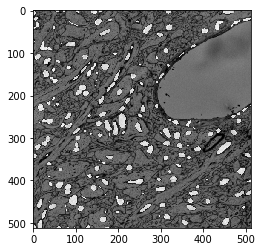

[[ 0.50604594  0.50126511  0.49836206 ...,  0.60567474  0.59981233
   0.57762873]
 [ 0.48714685  0.48462331  0.49499461 ...,  0.59928948  0.60190946
   0.59348369]
 [ 0.4687396   0.46127462  0.47739935 ...,  0.59590328  0.59216124
   0.5924719 ]
 ..., 
 [ 0.37805235  0.38313723  0.42793813 ...,  0.59787363  0.59667206
   0.60346532]
 [ 0.41109979  0.4092204   0.42855379 ...,  0.59878117  0.59195971
   0.61064404]
 [ 0.44918546  0.43049422  0.4288376  ...,  0.59791172  0.58097422
   0.58429283]]
[[ 129.04171753  127.82260132  127.0823288  ...,  154.447052    152.95214844
   147.29533386]
 [ 124.22245026  123.57894135  126.22362518 ...,  152.81881714
   153.48690796  151.33833313]
 [ 119.52859497  117.62503052  121.73683167 ...,  151.95533752
   151.00111389  151.08033752]
 ..., 
 [  96.40335083   97.69998932  109.1242218  ...,  152.45777893
   152.15136719  153.88365173]
 [ 104.83044434  104.35120392  109.28121948 ...,  152.68919373
   150.94972229  155.7142334 ]
 [ 114.54228973  109.77

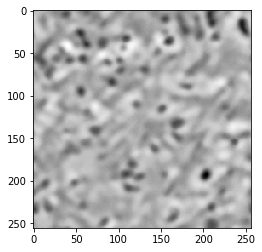

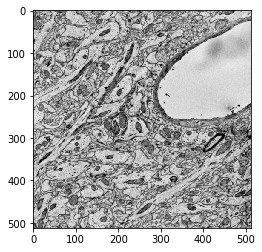

In [9]:
images = args[0][-1][-1][:,:,0]
images -= images.min()
images = images/images.max()
src = read("1,80_prealigned", (10000,10000),3*512)
vis.show(np.multiply(images<0.5, 1)+0.9*src)
blend = get_blend_map(256,512)

print(images)
images = normalize(images)

print(images)

images = imresize(images,(512,512))
images= np.multiply(images, blend)
images = images.astype(np.int32)
images = images[0:256, 0:256]+images[256:512, 256:512]+images[0:256, 256:512]+images[256:512, 0:256 ]
print(images.max())
vis.show(images)
vis.show(read("1,80_prealigned", (10000,10000),3*512))
#save(read("12,1_prealigned", (10000,10000),3*224))

### Transforming slices

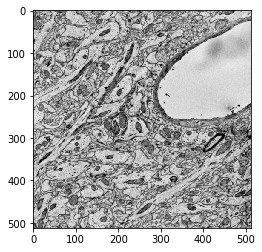

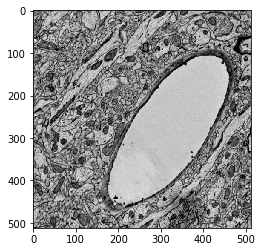

In [10]:
vis.show(read("1,80_prealigned", (10000,10000),512*3))
vis.show(s[0])

In [11]:
# Process by batches
def process(name, (x,y), dset, blend_map, scale=3):
    model_run =[model.source_alpha]
    
    feed_dict ={model.image: np.array([read(name, (x+i*scale*256,y),scale*512) for i in range(8)]), 
                model.template: t, 
                model.dropout: 1}
    args = model.sess.run(model_run,feed_dict=feed_dict)
    
    for i in range(8):
        image = args[0][-1][i][:,:,0]
        image = normalize(image)
        #image = 255*np.ones((512,512))
        image = imresize(image,(scale*512,scale*512))
        image = np.multiply(image, blend_map)
        image = image.astype(np.uint8)
        #image = image + read(name+"_transformed", (x+i*scale*256, y), scale*512)
        #print()
        #print(image.size)
        #vis.show(image)
        write(image, (x+i*scale*256, y), dset) 
    return image 


### Run on whole dataset

In [12]:
def process_dataset(name):
    blend_map = get_blend_map(3*256,3*512)
    #print(blend_map)
    shape = get_shape(name) #(30159, 40229)
    dset = create_dataset(name[0:2]+'10'+name[2:], shape=shape)
    step_x = 8*3*256
    step_y = 3*256
    #process(name, (0,39), dset, blend_map)
    for x in range(shape[0]//(step_x)):
        for y in range(shape[1]//(step_y)-2):
            #print((x,y))
            process(name, (x*step_x,y*step_y), dset, blend_map)

In [11]:
#process_dataset("1,4_prealigned")
#process_dataset("1,81_prealigned")

In [ ]:
done = [(1,2), (1,3)]
def process_all():
    for i in range(3):
        for x in range(98):
            if (i+2,x+2) in done:
                print('pass',i+1,x+2)
                continue
            try:
                process_dataset(str(i+1)+','+str(x+2)+'_'+'prealigned')
                done.extend((i+1, x+2))
                print(i+1,x+2)
            except:
                print('err',i+1,x+2)

In [ ]:
process_all()

('err', 1, 2)
('err', 1, 3)
('err', 1, 4)
(1, 5)
('err', 1, 6)
(1, 7)
('err', 1, 8)
(1, 9)
(1, 10)
('err', 1, 11)
(1, 12)
('err', 1, 13)
('err', 1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
('err', 1, 19)
(1, 20)
('err', 1, 21)
(1, 22)
(1, 23)
('err', 1, 24)
(1, 25)
(1, 26)
('err', 1, 27)
(1, 28)
('err', 1, 29)
(1, 30)
(1, 31)
('err', 1, 32)
(1, 33)
(1, 34)
(1, 35)
(1, 36)
(1, 37)
(1, 38)
('err', 1, 39)
('err', 1, 40)
(1, 41)
(1, 42)
(1, 43)
(1, 44)
(1, 45)
('err', 1, 46)
('err', 1, 47)
(1, 48)
(1, 49)
('err', 1, 50)
(1, 51)
('err', 1, 52)
(1, 53)
(1, 54)
(1, 55)
(1, 56)
(1, 57)
(1, 58)
(1, 59)
(1, 60)
(1, 61)
(1, 62)
(1, 63)
(1, 64)
('err', 1, 65)
(1, 66)
('err', 1, 67)
('err', 1, 68)
('err', 1, 69)
(1, 70)
(1, 71)
('err', 1, 72)
('err', 1, 73)
(1, 74)
('err', 1, 75)
(1, 76)
('err', 1, 77)
(1, 78)
(1, 79)
(1, 80)
(1, 81)
(1, 82)
(1, 83)
('err', 1, 84)
(1, 85)
(1, 86)
('err', 1, 87)
(1, 88)
(1, 89)
('err', 1, 90)
(1, 91)
(1, 92)
(1, 93)
(1, 94)
('err', 1, 95)
(1, 96)
(1, 97)
('err', 1, 98)
(

0.25
1.0


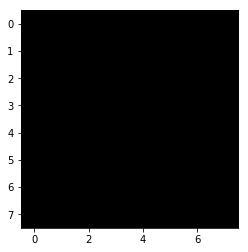

In [14]:
a = get_blend_map(8,16)
print(a.mean())
b = a[0:8,0:8]+a[8:16, 8:16] + a[0:8,8:16]+a[8:16, 0:8]
print(b.mean())
vis.show(a[0:8,0:8]+a[8:16, 8:16] + a[0:8,8:16]+a[8:16, 0:8])

In [11]:
a = "1,80_prealigned"

In [ ]:
print('3', 1,2)